In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from os.path import join
from skimage import io, transform
import pandas as pd
import matplotlib.pyplot as plt 

from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils

from sklearn.model_selection import train_test_split

In [5]:
datadir = '/scratche/data/diabetic-retinopathy-detection/train-orig'

In [14]:
df_labels = pd.read_csv('/scratche/data/diabetic-retinopathy-detection/trainOrigLabels.csv')
df_labels['level'] = pd.to_numeric(df_labels['level'])
temp = df_labels.groupby('level').count()
temp['perc'] = np.around(temp['image']*100/temp['image'].sum(), 2)
temp

,image,perc
level,,
0,25810,73.48
1,2443,6.95
2,5292,15.07
3,873,2.49
4,708,2.02


In [8]:
df_train, df_val = train_test_split(df_labels, test_size=0.15, random_state=42, stratify=df_labels['level'], shuffle=True)

In [15]:
temp = df_train.groupby('level').count()
temp['perc'] = np.around(temp['image']*100/temp['image'].sum(), 2)
temp

,image,perc
level,,
0,21938,73.48
1,2077,6.96
2,4498,15.07
3,742,2.49
4,602,2.02


In [16]:
temp = df_val.groupby('level').count()
temp['perc'] = np.around(temp['image']*100/temp['image'].sum(), 2)
temp

,image,perc
level,,
0,3872,73.49
1,366,6.95
2,794,15.07
3,131,2.49
4,106,2.01


In [23]:
df_train.to_csv('/scratche/data/diabetic-retinopathy-detection/trainLabels.csv', index=False)
df_val.to_csv('/scratche/data/diabetic-retinopathy-detection/valLabels.csv', index=False)

In [24]:
os.makedirs('/scratche/data/diabetic-retinopathy-detection/train', exist_ok=True)
os.makedirs('/scratche/data/diabetic-retinopathy-detection/val', exist_ok=True)

In [25]:
for phase in ['train', 'val']:
    if phase == 'train':
        df = df_train
    if phase == 'val':
        df = df_val
        
    print(f'{phase} started.')
    for i, (idx, row) in enumerate(df.iterrows()):
        orig_path = f'/scratche/data/diabetic-retinopathy-detection/train-orig/{row["image"]}.jpeg'
        new_path = f'/scratche/data/diabetic-retinopathy-detection/{phase}/{row["image"]}.jpeg'

        os.system(f'cp {orig_path} {new_path}')
        
        if i % 99 == 0:
            print(f'{i + 1} images copied.')
    print(f'{phase} done.')

train started.
0 images copied.
99 images copied.
198 images copied.
297 images copied.
396 images copied.
495 images copied.
594 images copied.
693 images copied.
792 images copied.
891 images copied.
990 images copied.
1089 images copied.
1188 images copied.
1287 images copied.
1386 images copied.
1485 images copied.
1584 images copied.
1683 images copied.
1782 images copied.
1881 images copied.
1980 images copied.
2079 images copied.
2178 images copied.
2277 images copied.
2376 images copied.
2475 images copied.
2574 images copied.
2673 images copied.
2772 images copied.
2871 images copied.
2970 images copied.
3069 images copied.
3168 images copied.
3267 images copied.
3366 images copied.
3465 images copied.
3564 images copied.
3663 images copied.
3762 images copied.
3861 images copied.
3960 images copied.
4059 images copied.
4158 images copied.
4257 images copied.
4356 images copied.
4455 images copied.
4554 images copied.
4653 images copied.
4752 images copied.
4851 images copied.

In [29]:
num_classes = len(pd.unique(df_labels['level']))

In [5]:
len(os.listdir('/scratche/data/diabetic-retinopathy-detection/train-orig'))

35126

In [6]:
# Create dataset class

class DiabRetinopathyDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.annotations = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = join(self.root_dir, self.annotations.iloc[idx]['image'])+'.jpeg'
        image = io.imread(img_name)
        image = Image.fromarray(image)
        label = self.annotations.iloc[idx]['level']
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['image'] = np.array(sample['image'])

        return sample
    

In [7]:
# Instantiate dataset object
datasets = {}
for phase in ['train', 'val']:
    datasets[phase] = DiabRetinopathyDataset(root_dir=f'/scratche/data/diabetic-retinopathy-detection/{phase}', 
                                             csv_file=f'/scratche/data/diabetic-retinopathy-detection/{phase}Labels.csv',
                                             transform=transforms.Compose([
                                                 transforms.Resize(256),
                                                 transforms.RandomCrop(224),
                                                 transforms.ToTensor()
                                             ]))

    dataloaders[p] = DataLoader(datasets[phase], batch_size=32,
                             shuffle=True, num_workers=10)

0 (3, 224, 224) 0


TypeError: Invalid shape (3, 224, 224) for image data

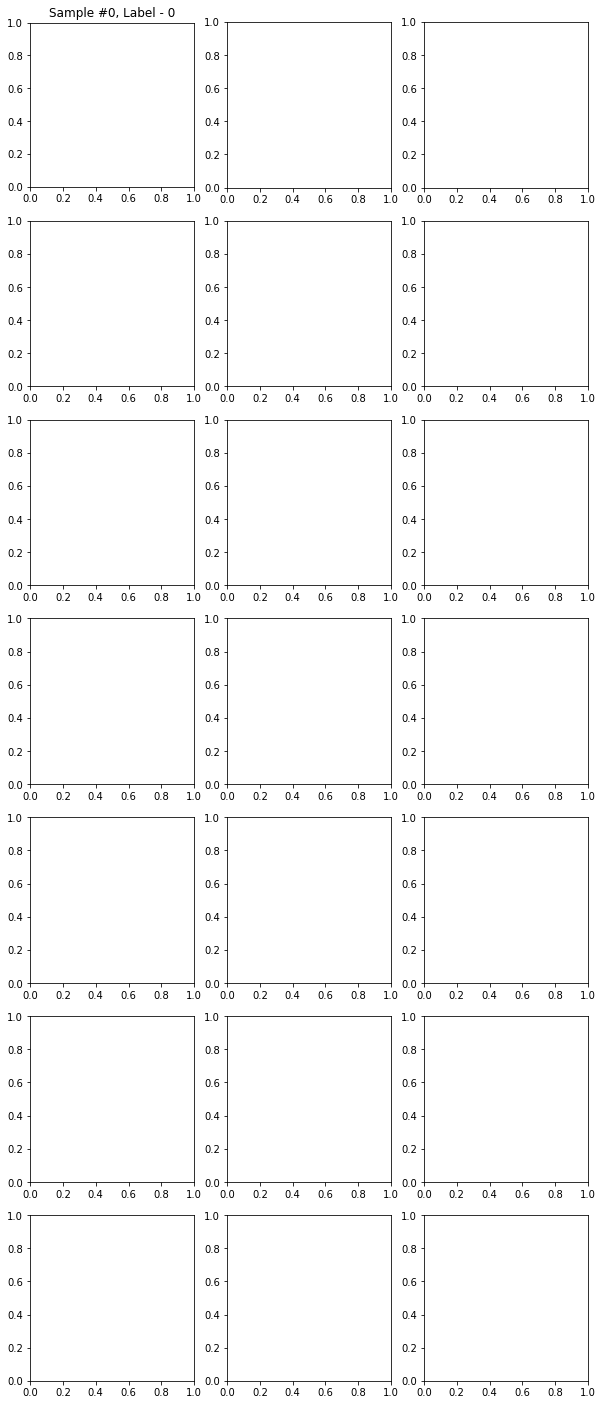

In [9]:
# Plot dataset elements
fig, axs = plt.subplots(figsize=(10, 25), nrows=7, ncols=3)

for i, sample in enumerate(dataset):

    print(i, sample['image'].shape, sample['label'])

    ax = axs.flat[i]
    ax.set_title(f'Sample #{i}, Label - {sample["label"]}')
    ax.imshow(sample['image'])
    ax.axis('off')

    if i == 20:
        plt.show()
        break

In [41]:
from torchvision import models
model = models.vgg16(pretrained=True)

In [42]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [43]:
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Training

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for epoch in range(2):  # loop over the dataset multiple times
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  
        running_loss = 0.0
        for i, data in enumerate(dataloaders[phase]):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['image']
            labels = data['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            model = model.to(device)
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.size(0)
            if i % 50 == 49:    # print every 50 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ((i+1)*inputs.size(0))))
                
        epoch_loss = running_loss / datasets['train'].__len__()
        print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            

print('Finished Training')

[1,    50] loss: 1.581
[1,   100] loss: 1.576
[1,   150] loss: 1.576
[1,   200] loss: 1.575
[1,   250] loss: 1.578
[1,   300] loss: 1.579
[1,   350] loss: 1.579
[1,   400] loss: 1.581
[1,   450] loss: 1.580
[1,   500] loss: 1.580
[1,   550] loss: 1.580
[1,   600] loss: 1.579
[1,   650] loss: 1.578
[1,   700] loss: 1.580
[1,   750] loss: 1.580
[1,   800] loss: 1.580
[1,   850] loss: 1.580
[1,   900] loss: 1.580
train Loss: 1.5798
[1,    50] loss: 1.563
[1,   100] loss: 1.562
[1,   150] loss: 1.562
[1,   200] loss: 1.560
[1,   250] loss: 1.559
[1,   300] loss: 1.558
[1,   350] loss: 1.557
[1,   400] loss: 1.557
[1,   450] loss: 1.556
[1,   500] loss: 1.556
[1,   550] loss: 1.556
[1,   600] loss: 1.557
[1,   650] loss: 1.556
